# Transformação de dados

Código em Python para análise de dados. 


Este notebook foi desenvolvido para o ambiente GOOGLE COLAB ([colab.research.google.com](https://colab.research.google.com)).

Prof. Hugo de Paula



# Inicialização da plataforma

A célula a seguir inicializa a plataforma, carregando as bibliotecas que serão relevantes para o trabalho em seguida.

## Bibliotecas



```numpy``` -- usada para processamento numérico.

```pandas``` -- usada para manipulação de bases de dados.

```pyplot``` -- usada para visualização de dados.

```seaborn``` -- usada para visualização de dados.



In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

np.set_printoptions(threshold=None, precision=2)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('precision', 2)

# Base de dados do Titanic

Essa base de dados pode ser obtida no Kaggle, no endereço: 
[www.kaggle.com/c/titanic/data](https://www.kaggle.com/c/titanic/data)

### DESCRIÇÃO DOS ATRIBUTOS:


*   ```survival``` --  Sobrevivente (0 = Não; 1 = Sim)
*   ```pclass``` --  Classe do passageiro (1 = 1a classe; 2 = 2a classe; 3 = 3a classe)
*   ```name``` --  Nome (str)
*   ```sex``` --  Sexo (male; female)
*   ```age``` --  Idade (numérica)
*   ```sibsp``` --  Número de irmãos/conjuges à bordo
*   ```parch``` --  Número de pais/filhos à bordo
*   ```ticket``` --  Número da passagem
*   ```fare``` --  Tarifa do passageiro
*   ```cabin``` --  Cabine
*   ```embarked``` --  Porto de embarque (C = Cherbourg; Q = Queenstown; S = Southampton)

### UPLOAD DE ARQUIVO LOCAL:

Para fazer o upload de bases de dados, deve-se usar o objeto ```files``` do pacote ```goggle.colab```.

Deve-se fazer o upload do arquivo "train.csv" disponível na pasta "Datasets\Titanic".




In [0]:
from google.colab import files

uploaded = files.upload()


In [0]:

titanic_train = pd.read_csv(next(iter(uploaded.keys())))

print("\nDimensões de Titanic:\n{0}\n".format(titanic_train.shape))
print("\nCampos de Titanic:\n{0}\n".format(list(titanic_train.keys())))
print("\nTipos dos dados:\n{0}\n".format(titanic_train.dtypes))


### ESTATÍSTICA DESCRITIVA DOS DADOS

O comando describe exibe prioritariamente os campos numéricos. Deve-se isolar os campos categóricos para serem exibidos posteriormente.

In [0]:
# Exibe apenas os campos numméricos:

print(titanic_train.describe())

# Para se ter uma visão dos atributos categóricos, os atributos não numéricos 
# são descartados. 

categ = titanic_train.dtypes[titanic_train.dtypes == "object"].index

print("\n", titanic_train[categ].describe(), sep='\n')


### REMOÇÃO DE ATRIBUTOS IRRELEVANTES

Os atributos ```survival``` (objetivo ou label), e atributos que descrevem os passageiros ou os agrupam em categorias são úteis e serão mantidos, por exemplo: ```Pclass```, ```Sex```, ```Age```, ```SibSp```, ```Parch```, ```Fare``` e ```Embarked```. 


* ```passengerId``` é apenas uma chave primária para identificar um passageiro e não é relevante para o problema.

* ```Name``` náo é útil para previsão, mas pode ser útil para identificação dos registros ou pós-processamento (por exemplo, extrair o último nome).

* ```Ticket``` não identifica o registro e nem descreve o passageiro, por isso, deve ser removido.

* ```Cabin``` não identifica bem os passageiros, mas pode ser útil utilizarmos o padrão letra+numero para descrever os passageiros pelo andar do local da cabine.

In [0]:
del titanic_train["PassengerId"]
del titanic_train["Ticket"]

# Verifique que o número de atributos reduziu para 10.

print("\nDimensões de Titanic:\n{0}\n".format(titanic_train.shape))

### TRANSFORMAÇÃO DE VARIÁVEIS

#### Converter numérico em categórico.

Variáveis categóricas codificadas numericamente possuem baixa legibilidade. Portanto, podem ser candidatas a serem recodificadas.

In [0]:
# OBSERVAÇÃO: se a base for usada para a competição do kaggle, o atributo
# alvo, que é o campo 'survived' não deve ser recodificada.

new_survived = pd.Categorical(titanic_train["Survived"])
new_survived = new_survived.rename_categories(["Morreu","Sobreviveu"])              
titanic_train["Survided"] = new_survived

new_Pclass = pd.Categorical(titanic_train["Pclass"], ordered=True)
new_Pclass = new_Pclass.rename_categories(["1aClasse","2aClasse","3aClasse"])     
titanic_train["Pclass"] = new_Pclass

print("\nTipos dos dados:\n{0}\n".format(titanic_train.dtypes))
categ = titanic_train.dtypes[titanic_train.dtypes == "category"].index
print("\n", titanic_train[categ].describe(), sep='\n')



#### Converter atributo através de processamento de string (usando *list comprehension*).

No atributo ```Cabin```,  parece que o padrão letra+número (veja exibição a seguir) indica que uma cabine pertence a algum andar, ou nível. Podemos agrupar o atributo Cabin pela letra inicial da cabine.


In [0]:
#Exibe valores únicos

print("\nValores únicos do atributo Cabin:",titanic_train["Cabin"].unique(), sep='\n')

# Converte o dado para String

char_cabin = titanic_train["Cabin"].astype(str)

# Pega apenas a primeira letra

new_cabin = pd.Categorical([cabin[0] for cabin in char_cabin])
titanic_train["Cabin"] = new_cabin

print("\nValores únicos do atributo Cabin:",titanic_train["Cabin"].unique(), sep='\n')

### VALORES OMISSOS OU INCONSISTENTES

Em atributos numéricos , as possibilidades são:

1. substituir por zeros;
2. substituir por um valor médio ou mediano;
3. estimar valores usando modelos estatísticos ou preditivos;
4. particionar a base em registros completos e registros incompletos.

Vamos analisar o atributo ```Age``` para tratarmos os valores omissos.

In [0]:
titanic_train.hist(column='Age',    # Coluna a ser plotada
                   figsize=(9,6),   # Tamanho do gráfico
                   bins=20)         # Numero de colunas do histogram

O dado possui uma distribuição próxima da distribuição Normal. Vamos usar a mediana para preencher os valores faltantes.

In [0]:
mediana = np.median([el for el in titanic_train["Age"] if (np.isnan(el) == False)])

new_age = np.where(titanic_train["Age"].isnull(), # condição
                   mediana,                       # valor se verdadeiro
                   titanic_train["Age"])          # valor se falso
titanic_train["Age"] = new_age

print("\nAnálise do novo atributo Age:")
print(titanic_train["Age"].describe())

titanic_train.hist(column='Age',    # Coluna a ser plotada
                   figsize=(9,6),   # Tamanho do gráfico
                   bins=20)         # Numero de colunas do histogram


### DETECTANDO OUTLIERS

Outliers são valores extremos. A estatística descritiva, em geral, provê um bom indicativo da presença de outliers, com valores máximos e mínimo muito distantes; o valor da média muito próximo de um máximo ou mínimo, mostrando problema de distribuição dos dados.

In [0]:
titanic_train["Fare"].plot(kind="box", figsize=(9,9))

index = np.where(titanic_train["Fare"] == max(titanic_train["Fare"]) )

print("Registros com valores extremos:",titanic_train.loc[index], sep='\n')


### CRIANDO NOVOS ATRIBUTOS

Vamos criar uma nova variável ```Family```, que irá unir, conjude e irmãos (```SibSp```) com pais e filhos (```Parch```).

In [0]:
titanic_train["Family"] = titanic_train["SibSp"] + titanic_train["Parch"]

# Encontrando quem tem a maior família À bordo

most_family = np.where(titanic_train["Family"] == max(titanic_train["Family"]))

print("\nAs maiores famílias à bordo:\n{0}".format(titanic_train.loc[most_family]))


 Os atributos agora estão redundantes, ou muito correlacionados, como podemos ver com a matriz de correlação. A matriz só funciona com tipos de ddos numéricos. Será possível perceber que a variável ```Family``` terá forte correlação (acima de 0.75) com ```SibSp``` e ```Parch```.

In [0]:
int_fields = titanic_train.dtypes[titanic_train.dtypes == "int64"].index
corr = np.corrcoef(titanic_train[int_fields].transpose())
correlacao = pd.DataFrame(data=corr, index=int_fields, columns=int_fields)

print("\nMatriz de correlação dos atributos inteiros:\n{0}".format(correlacao))


# Base de dados do Gazola de imóveis em São Paulo

A base possui 14 campos: um identificador, 11 atributos e 2 rótulos (Cub e Preço $).

### UPLOAD DE ARQUIVO LOCAL:

Deve-se fazer o upload do arquivo "Gazola_dados_apartamento_resumo.xls" disponível na pasta "Datasets".



In [2]:
from google.colab import files

uploaded = files.upload()


Saving Gazola_dados_apartamento_resumo.xls to Gazola_dados_apartamento_resumo.xls


In [5]:
gazola = pd.read_excel(next(iter(uploaded.keys())), sheet_name=1)

print("\nDimensões:\n{0}\n".format(gazola.shape))
print("\nCampos:\n{0}\n".format(list(gazola.keys())))
print("\nTipos dos dados:\n{0}\n".format(gazola.dtypes))
print(gazola.describe(percentiles=[]))




Dimensões:
(397, 14)


Campos:
['imóvel', 'DepEmp', 'Conserv', 'Classif', 'Elev', 'RegHom', 'Suíte', 'Garag', 'Dorm', 'Idade', 'Energia', 'Artot', 'Cub', 'Preço($)']


Tipos dos dados:
imóvel        int64
DepEmp        int64
Conserv       int64
Classif       int64
Elev          int64
RegHom        int64
Suíte         int64
Garag         int64
Dorm          int64
Idade         int64
Energia       int64
Artot       float64
Cub         float64
Preço($)    float64
dtype: object

       imóvel  DepEmp  Conserv  Classif    Elev  RegHom   Suíte   Garag  \
count  397.00  397.00   397.00   397.00  397.00  397.00  397.00  397.00   
mean   199.00    1.39     3.01     1.93    1.83    5.54    1.61    1.99   
std    114.75    0.49     1.02     0.61    0.38    1.97    0.49    0.56   
min      1.00    1.00     1.00     1.00    1.00    1.00    1.00    1.00   
50%    199.00    1.00     3.00     2.00    2.00    6.00    2.00    2.00   
max    397.00    2.00     4.00     3.00    2.00   11.00    3.00    3.

### PREPARANDO A BASE PARA O TREINAMENTO

É necessário remover o identificador, retirar o Cub e definir o preço como atributo alvo.

```train_test_split``` irá separar a base em "base de treinamento" e "base de teste" a partir de uma amostragem aleatória.


Base de treinamento:(357, 11)
Base de teste:(40, 11)


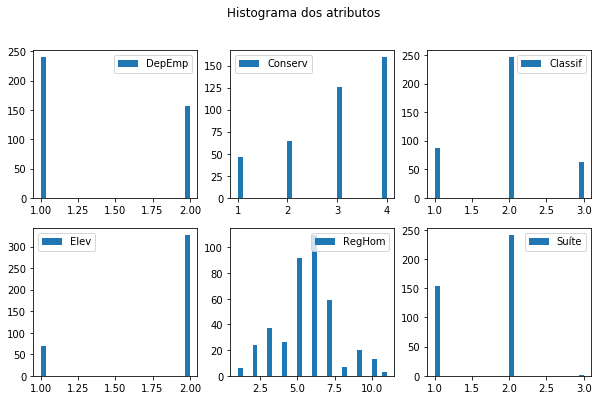

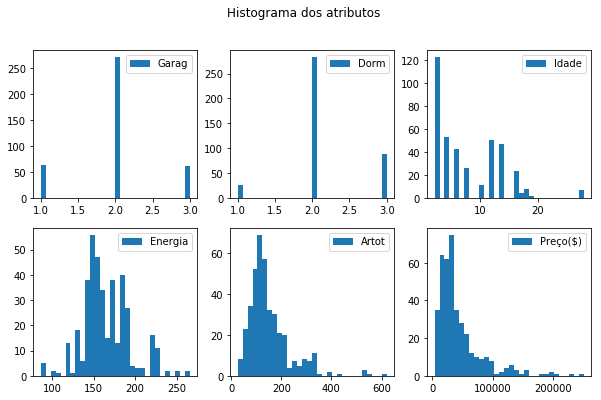

In [7]:
X = gazola.iloc[:,1:(gazola.shape[1] - 2)]

y = gazola.iloc[:,(gazola.shape[1] - 1)]

# Recupera os nomes dos atributos

atributos = list(gazola)[1:(gazola.shape[1] - 2)]
rotulo = list(gazola)[(gazola.shape[1] - 1)]

# Exibe o histograma dos atributos.

fig, ax = plt.subplots(2, 3, figsize=(10, 6))
plt.suptitle("Histograma dos atributos")

for i in range(2):
    for j in range(3):
        ax[i, j].hist(X.iloc[:,(i*3 + j)], label=atributos[i*3+j], bins=30)
        ax[i, j].legend()

fig, ax = plt.subplots(2, 3, figsize=(10, 6))
plt.suptitle("Histograma dos atributos")

for i in range(2):
    for j in range(3):
        if j == 2 and i == 1:
            ax[i, j].hist(y.iloc[:],label=rotulo,bins=30)
        else:            
            ax[i, j].hist(X.iloc[:,(i*3 + j+6)],label=atributos[i*3 + j+6], bins=30)
        ax[i, j].legend()


# Amostragem de dados

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

print("Base de treinamento:{0}".format(X_train.shape))
print("Base de teste:{0}".format(X_test.shape))




### TREINAMENTO POR REGRESSÃO LINEAR

```fit()``` realiza o ajusto do modelo (treinamento).

```predict()``` aplica o modelo sobre novos dados.


Acurácia da base de treinamento: 0.92
Acurácia da base de testes: 0.82
Descrição do modelo: 
w: ['DepEmp: 240.34', 'Conserv: 1895.61', 'Classif: 9117.99', 'Elev: -2617.38', 'RegHom: 2457.82', 'Suíte: -6619.12', 'Garag: -3094.77', 'Dorm: -1511.09', 'Idade: 80.60', 'Energia: -74.78', 'Artot: 390.57']  b: -15469.97
Número de atributos usados: 11
Erro percentual:
 Média: 0.25  Max: 0.87   Min: 0.00


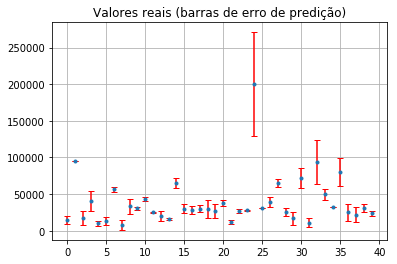

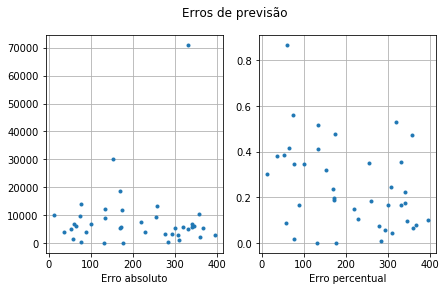

In [8]:
lnr = LinearRegression()

lnr.fit(X_train, y_train)

y_prev = lnr.predict(X_test)

print("Acurácia da base de treinamento: {:.2f}".format(lnr.score(X_train, y_train)))
print("Acurácia da base de testes: {:.2f}".format(lnr.score(X_test, y_test)))

print("Descrição do modelo: ")
s = ["{0}: {1:0.2f}".format(a, v) for a, v in zip(atributos, lnr.coef_)]
print("w: {}  b: {:.2f}".format(s, lnr.intercept_))
print("Número de atributos usados: {}".format(np.sum(lnr.coef_ != 0)))

# Calcula o erro absoluto e o erro percentual da regressao linear
errolnr = np.abs(y_test - y_prev)
erroperc = errolnr / list(y_test)

print('Erro percentual:\n Média: {0:.2f}  Max: {1:.2f}   Min: {2:.2f}'
      .format(np.mean(erroperc), np.max(erroperc), np.min(erroperc)))

plt.figure(figsize=(6, 4))
plt.errorbar(np.arange(y_test.size), list(y_test), yerr=errolnr,
             fmt='.', ecolor='r', capsize=3)
plt.title("Valores reais (barras de erro de predição)")
plt.grid()

fig, ax = plt.subplots(1, 2, figsize=(7, 4))
plt.suptitle("Erros de previsão")
ax[0].plot(errolnr,'.')
ax[0].set_xlabel("Erro absoluto")
ax[0].grid()
ax[1].plot(erroperc,'.')
ax[1].set_xlabel("Erro percentual")
ax[1].grid()



### TRANSFORMAÇÃO DE DADOS NUMÉRICOS

Vamos explorar a transformação de dados, para resolver problemas de distribuição e a normalização de dados.


--------------- Regressão Linear Normalizada ---------------
Acurácia da base de treinamento: 0.96
Acurácia da base de testes: 0.93
Descrição do modelo: 
w: ['DepEmp: 0.02', 'Conserv: 0.12', 'Classif: 0.14', 'Elev: -0.00', 'RegHom: 0.23', 'Suíte: 0.07', 'Garag: 0.00', 'Dorm: 0.02', 'Idade: 0.02', 'Energia: -0.11', 'Artot: 1.41']  b: 3.57

------------------  Comparação de pesos   ------------------
Original:
 w: ['DepEmp: 240.34', 'Conserv: 1895.61', 'Classif: 9117.99', 'Elev: -2617.38', 'RegHom: 2457.82', 'Suíte: -6619.12', 'Garag: -3094.77', 'Dorm: -1511.09', 'Idade: 80.60', 'Energia: -74.78', 'Artot: 390.57']  b: -15469.97
Normalizado:
 w: ['DepEmp: 0.02', 'Conserv: 0.12', 'Classif: 0.14', 'Elev: -0.00', 'RegHom: 0.23', 'Suíte: 0.07', 'Garag: 0.00', 'Dorm: 0.02', 'Idade: 0.02', 'Energia: -0.11', 'Artot: 1.41']  b: 3.57


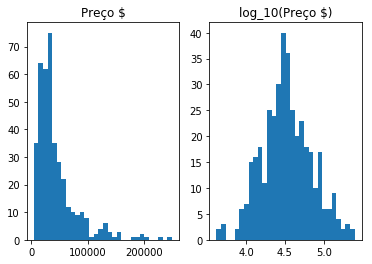

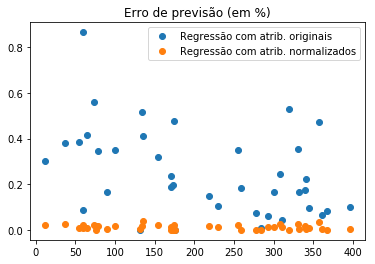

In [9]:

# Os atributos possuem faixas de valores diferentes, que influencia os pesos 
# dos coeficientes da regressão. Vamos trabalhar melhor os atributos.

X_scale = X

# Iremos aplicar o logaritmo em "Energia total", "Área total" e "Preço $".

X_scale['Energia'] = np.log10(X['Energia'])
X_scale['Artot'] = np.log10(X['Artot'])
y_scale = np.log10(y)

# Normalização Min-Max dos dados.

min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(X_scale)
X_scale = min_max_scaler.transform(X_scale)

fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax[0].hist(y,bins=30, label='Preço $')
ax[0].set_title('Preço $')
ax[1].hist(y_scale,bins=30, label='log10(Preço $)')
ax[1].set_title('log_10(Preço $)')


X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scale, y_scale, test_size=0.1, random_state=0)

lnr2 = LinearRegression().fit(X_train2, y_train2)

y_prev2 = lnr2.predict(X_test2)

errolnr2 = np.abs(y_test2 - y_prev2)
errolnr2perc = np.abs(y_test2 - y_prev2)/y_test2

plt.figure(figsize=(6, 4))
plt.plot(erroperc,'o', label='Regressão com atrib. originais')
plt.plot(errolnr2perc,'o', label='Regressão com atrib. normalizados')
plt.title("Erro de previsão (em %)")
plt.legend()

print("\n--------------- Regressão Linear Normalizada ---------------")
print("Acurácia da base de treinamento: {:.2f}".format(lnr2.score(X_train2, y_train2)))
print("Acurácia da base de testes: {:.2f}".format(lnr2.score(X_test2, y_test2)))
print("Descrição do modelo: ")
s = ["{0}: {1:0.2f}".format(a, v) for a, v in zip(atributos, lnr2.coef_)]
print("w: {}  b: {:.2f}".format(s, lnr2.intercept_))


print("\n------------------  Comparação de pesos   ------------------")
s = ["{0}: {1:0.2f}".format(a, v) for a, v in zip(atributos, lnr.coef_)]
print("Original:\n w: {}  b: {:.2f}".format(s, lnr.intercept_))
s = ["{0}: {1:0.2f}".format(a, v) for a, v in zip(atributos, lnr2.coef_)]
print("Normalizado:\n w: {}  b: {:.2f}".format(s, lnr2.intercept_))

